In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import gc
import json
import copy
import time
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 32 s, sys: 1.8 s, total: 33.8 s
Wall time: 31.8 s


In [6]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [7]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [8]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [9]:
train_df = train_df.rename({'event_code_title':'title_event_code'}, axis='columns')
test_df = test_df.rename({'event_code_title':'title_event_code'}, axis='columns')

In [10]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [11]:
comp_train_df = feature_engineering.feature_generation_2(train_samples, False, assess_titles=assess_titles,
                                                         list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
                                                         activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
                                                         win_code=win_code,
                                                         activities_map=activities_map)

In [12]:
extra_training = []
comp_test_df = feature_engineering.feature_generation_2(test_samples, True, assess_titles=assess_titles,
                                                         list_of_event_code=list_of_event_code, list_of_event_id=list_of_event_id,
                                                         activities_labels=activities_labels, all_title_event_code=list_of_event_code_title,
                                                         win_code=win_code,
                                                         activities_map=activities_map,
                                                         extra_training=extra_training,
                                                         include_all=False)

In [13]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Bird Measurer (Assessment),acc_Chest Sorter (Assessment),acc_Cart Balancer (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,d3640339,3edf6747,0ce40006,c189aaf2,71e712d8,90efca10,598f4598,1b54d27f,2a444e03,5859dfb6,562cec5f,c51d8688,19967db1,c277e121,45d01abe,5154fc30,3dcdda7f,16667cc5,15a43e5b,29bdd9ba,b7530680,a6d66e51,3ddc79c3,2fb91ec1,7f0836bf,3bb91ced,1340b8d7,e4d32835,44cb4907,a8a78786,bb3e370b,9ee1c98c,abc5811c,14de4c5d,15eb4a7d,fbaf3456,f54238ee,d122731b,37937459,73757a5e,a1e4395d,f6947f54,04df9b66,f3cd5473,2dc29e21,85de926c,4a09ace1,a52b92d5,4e5fc6f5,b012cd7f,8d84fa81,3bf1cf26,4c2ec19f,ecaab346,d9c005dd,dcaede90,47efca07,5d042115,47f43a44,bdf49a58,c74f40cd,d38c2fd7,a5be6304,8d748b58,cf7638f3,6aeafed4,4ef8cdd3,69fdac0a,91561152,7961e599,56817e2b,7040c096,7d093bf9,6f445b57,d185d3ea,1c178d24,e5734469,9d4e7b25,15ba1109,363c86c9,6f8106d9,a76029ee,3d8c61b0,6f4adc4b,55115cbd,c2baf0bd,1af8be29,5f5b2617,01ca3a3c,6f4bd64e,c6971acf,f806dc10,3a4be871,d02b7a8e,756e5507,a1bbe385,67439901,1375ccb7,38074c54,2b9272f4,9b23e8ee,3bfd1a65,804ee27f,5348fd84,26a5a3dd,acf5c23f,29f54413,dcb55a27,a8efe47b,7dfe6d8a,83c6c409,1996c610,92687c59,84b0e0c8,b80e5e84,89aace00,5e109ec3,7525289a,4074bac2,15f99afc,ec138c1c,0330ab6a,587b5989,c54cf6c5,9ed8f6da,36fa3ebe,fcfdffb6,51102b85,49ed92e9,7d5c30a2,b2dba42b,a592d54e,c0415e5c,65a38bf7,9b4001e4,77c76bc5,6088b756,c7f7f0e1,e5c9df6f,df4940d3,99abe2bb,0d18d96c,bd701df8,3393b68b,7da34a02,b120f2ac,5b49460a,bcceccc6,77261ab5,88d4a5be,9c5ef70c,9554a50b,f7e47413,ad148f58,a8876db3,cb6010f8,3323d7e9,74e5f8a7,119b5b02,f32856e4,155f62a4,7372e1a5,51311d7a,6043a2b4,28a4eb9a,709b1251,b74258a0,1325467d,67aa2ada,bfc77bd6,6077cc36,05ad839b,71fe8f75,eb2c19cd,f71c4741,a7640a16,c58186bf,e04fb33d,3afde5dd,3ccd3f02,5a848010,b5053438,e64e2cfd,77ead60d,250513af,6c930e6e,262136f4,e9c52111,c1cac9a2,ac92046e,ea296733,7ab78247,5f0eb72c,8fee50e2,9e34ea74,828e68f9,763fc34e,86c924c4,9ce586dd,...,4080Bug Measurer (Activity),4090Chow Time,4080Chest Sorter (Assessment),4020Bottle Filler (Activity),4045Bubble Bath,3010Egg Dropper (Activity),3121Happy Camel,3110All Star Sorting,4070Watering Hole (Activity),4030Mushroom Sorter (Assessment),3110Fireworks (Activity),3110Air Show,2070Dino Dive,3010Chow Time,4020Air Show,4100Air Show,4020Chow Time,2010Pan Balance,4030Chest Sorter (Assessment),4020Leaf Leader,4090Sandcastle Builder (Activity),4080Sandcastle Builder (Activity),4020Dino Drink,4020All Star Sorting,4020Chest Sorter (Assessment),2000Pirate's Tale,4095All Star Sorting,2000Lifting Heavy Things,2035Bubble Bath,4030Flower Waterer (Activity),2000Fireworks (Activity),2070Dino Drink,3020Crystals Rule,3110Pan Balance,4020Bird Measurer (Assessment),4070Fireworks (Activity),4095Bubble Bath,3021All Star Sorting,2075Dino Drink,4095Leaf Leader,4050Crystals Rule,2020Leaf Leader,4090Crystals Rule,3021Cauldron Filler (Assessment),2081Scrub-A-Dub,2030Bottle Filler (Activity),4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),4010Happy Camel,4022Chicken Balancer (Activity),3010Pan Balance,4080Bottle Filler (Activity),4020Cart Balancer (Assessment),3120Scrub-A-Dub,4030Happy Camel,4100Mushroom Sorter (Assessment),3110Egg Dropper (Activity),4070Egg Dropper (Activity),4010Dino Drink,2030Mushroom Sorter (Assessment),2080Scrub-A-Dub,4010All Star Sorting,4080Fireworks (Activity),4090Dino Dive,4070Chow Time,4031Dino Drink,4090All Star Sorting,3021Bubble Bath,4070Cart Balancer (Assessment),2020Bottle Filler (Activity),3010Dino Dive,2035Mushroom Sorter (Assessment),4040Happy Camel,4070Mushroom Sorter (Assessment),200012 Monkeys,4100Cauldron Filler (Assessment),3121Leaf Leader,3120Air Show,4090Bubble Bath,2020Happy Camel,4080Cauldron Filler (Assessment),3010Fireworks (Activity),3

In [14]:
comp_test_df

,Clip,Activity,Assessment,Game,acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Bird Measurer (Assessment),acc_Chest Sorter (Assessment),acc_Cart Balancer (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,d3640339,3edf6747,0ce40006,c189aaf2,71e712d8,90efca10,598f4598,1b54d27f,2a444e03,5859dfb6,562cec5f,c51d8688,19967db1,c277e121,45d01abe,5154fc30,3dcdda7f,16667cc5,15a43e5b,29bdd9ba,b7530680,a6d66e51,3ddc79c3,2fb91ec1,7f0836bf,3bb91ced,1340b8d7,e4d32835,44cb4907,a8a78786,bb3e370b,9ee1c98c,abc5811c,14de4c5d,15eb4a7d,fbaf3456,f54238ee,d122731b,37937459,73757a5e,a1e4395d,f6947f54,04df9b66,f3cd5473,2dc29e21,85de926c,4a09ace1,a52b92d5,4e5fc6f5,b012cd7f,8d84fa81,3bf1cf26,4c2ec19f,ecaab346,d9c005dd,dcaede90,47efca07,5d042115,47f43a44,bdf49a58,c74f40cd,d38c2fd7,a5be6304,8d748b58,cf7638f3,6aeafed4,4ef8cdd3,69fdac0a,91561152,7961e599,56817e2b,7040c096,7d093bf9,6f445b57,d185d3ea,1c178d24,e5734469,9d4e7b25,15ba1109,363c86c9,6f8106d9,a76029ee,3d8c61b0,6f4adc4b,55115cbd,c2baf0bd,1af8be29,5f5b2617,01ca3a3c,6f4bd64e,c6971acf,f806dc10,3a4be871,d02b7a8e,756e5507,a1bbe385,67439901,1375ccb7,38074c54,2b9272f4,9b23e8ee,3bfd1a65,804ee27f,5348fd84,26a5a3dd,acf5c23f,29f54413,dcb55a27,a8efe47b,7dfe6d8a,83c6c409,1996c610,92687c59,84b0e0c8,b80e5e84,89aace00,5e109ec3,7525289a,4074bac2,15f99afc,ec138c1c,0330ab6a,587b5989,c54cf6c5,9ed8f6da,36fa3ebe,fcfdffb6,51102b85,49ed92e9,7d5c30a2,b2dba42b,a592d54e,c0415e5c,65a38bf7,9b4001e4,77c76bc5,6088b756,c7f7f0e1,e5c9df6f,df4940d3,99abe2bb,0d18d96c,bd701df8,3393b68b,7da34a02,b120f2ac,5b49460a,bcceccc6,77261ab5,88d4a5be,9c5ef70c,9554a50b,f7e47413,ad148f58,a8876db3,cb6010f8,3323d7e9,74e5f8a7,119b5b02,f32856e4,155f62a4,7372e1a5,51311d7a,6043a2b4,28a4eb9a,709b1251,b74258a0,1325467d,67aa2ada,bfc77bd6,6077cc36,05ad839b,71fe8f75,eb2c19cd,f71c4741,a7640a16,c58186bf,e04fb33d,3afde5dd,3ccd3f02,5a848010,b5053438,e64e2cfd,77ead60d,250513af,6c930e6e,262136f4,e9c52111,c1cac9a2,ac92046e,ea296733,7ab78247,5f0eb72c,8fee50e2,9e34ea74,828e68f9,763fc34e,86c924c4,9ce586dd,...,4080Bug Measurer (Activity),4090Chow Time,4080Chest Sorter (Assessment),4020Bottle Filler (Activity),4045Bubble Bath,3010Egg Dropper (Activity),3121Happy Camel,3110All Star Sorting,4070Watering Hole (Activity),4030Mushroom Sorter (Assessment),3110Fireworks (Activity),3110Air Show,2070Dino Dive,3010Chow Time,4020Air Show,4100Air Show,4020Chow Time,2010Pan Balance,4030Chest Sorter (Assessment),4020Leaf Leader,4090Sandcastle Builder (Activity),4080Sandcastle Builder (Activity),4020Dino Drink,4020All Star Sorting,4020Chest Sorter (Assessment),2000Pirate's Tale,4095All Star Sorting,2000Lifting Heavy Things,2035Bubble Bath,4030Flower Waterer (Activity),2000Fireworks (Activity),2070Dino Drink,3020Crystals Rule,3110Pan Balance,4020Bird Measurer (Assessment),4070Fireworks (Activity),4095Bubble Bath,3021All Star Sorting,2075Dino Drink,4095Leaf Leader,4050Crystals Rule,2020Leaf Leader,4090Crystals Rule,3021Cauldron Filler (Assessment),2081Scrub-A-Dub,2030Bottle Filler (Activity),4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),4010Happy Camel,4022Chicken Balancer (Activity),3010Pan Balance,4080Bottle Filler (Activity),4020Cart Balancer (Assessment),3120Scrub-A-Dub,4030Happy Camel,4100Mushroom Sorter (Assessment),3110Egg Dropper (Activity),4070Egg Dropper (Activity),4010Dino Drink,2030Mushroom Sorter (Assessment),2080Scrub-A-Dub,4010All Star Sorting,4080Fireworks (Activity),4090Dino Dive,4070Chow Time,4031Dino Drink,4090All Star Sorting,3021Bubble Bath,4070Cart Balancer (Assessment),2020Bottle Filler (Activity),3010Dino Dive,2035Mushroom Sorter (Assessment),4040Happy Camel,4070Mushroom Sorter (Assessment),200012 Monkeys,4100Cauldron Filler (Assessment),3121Leaf Leader,3120Air Show,4090Bubble Bath,2020Happy Camel,4080Cauldron Filler (Assessment),3010Fireworks (Activity),3

In [15]:
comp_train_df, comp_test_df = feature_engineering.preprocess(comp_train_df, comp_test_df)

In [16]:
comp_test_df = comp_test_df.groupby(['installation_id']).last().reset_index()

(array([1.7526e+04, 1.4200e+02, 1.9000e+01, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  19.5,  39. ,  58.5,  78. ,  97.5, 117. , 136.5, 156. ,
        175.5, 195. ]),
 <a list of 10 Patch objects>)

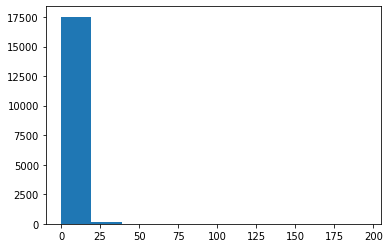

In [17]:
plt.hist(comp_train_df['Clip_diff_mean'])

(array([952.,  32.,   9.,   3.,   1.,   0.,   0.,   0.,   2.,   1.]),
 array([  0. ,  45.6,  91.2, 136.8, 182.4, 228. , 273.6, 319.2, 364.8,
        410.4, 456. ]),
 <a list of 10 Patch objects>)

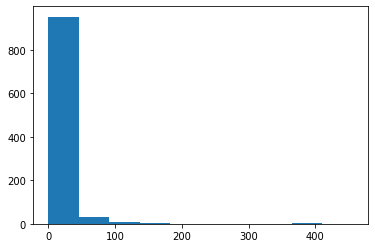

In [18]:
plt.hist(comp_test_df['Clip_diff_mean'])

### Remove zero columns

In [19]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

In [20]:
comp_train_df

,Clip,Activity,Assessment,Game,acc_Cauldron Filler (Assessment),acc_Mushroom Sorter (Assessment),acc_Bird Measurer (Assessment),acc_Chest Sorter (Assessment),acc_Cart Balancer (Assessment),2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4235,5010,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,d3640339,3edf6747,0ce40006,c189aaf2,71e712d8,90efca10,598f4598,1b54d27f,2a444e03,5859dfb6,562cec5f,c51d8688,19967db1,c277e121,45d01abe,5154fc30,3dcdda7f,16667cc5,15a43e5b,29bdd9ba,b7530680,a6d66e51,3ddc79c3,2fb91ec1,7f0836bf,3bb91ced,1340b8d7,e4d32835,44cb4907,a8a78786,bb3e370b,9ee1c98c,abc5811c,14de4c5d,15eb4a7d,fbaf3456,f54238ee,d122731b,37937459,73757a5e,a1e4395d,f6947f54,04df9b66,f3cd5473,2dc29e21,85de926c,4a09ace1,a52b92d5,4e5fc6f5,b012cd7f,8d84fa81,3bf1cf26,4c2ec19f,ecaab346,d9c005dd,dcaede90,47efca07,5d042115,47f43a44,bdf49a58,c74f40cd,d38c2fd7,a5be6304,8d748b58,cf7638f3,6aeafed4,4ef8cdd3,69fdac0a,91561152,7961e599,56817e2b,7040c096,7d093bf9,6f445b57,d185d3ea,1c178d24,e5734469,9d4e7b25,15ba1109,363c86c9,6f8106d9,a76029ee,3d8c61b0,6f4adc4b,55115cbd,c2baf0bd,1af8be29,5f5b2617,01ca3a3c,6f4bd64e,c6971acf,f806dc10,3a4be871,d02b7a8e,756e5507,a1bbe385,67439901,1375ccb7,38074c54,2b9272f4,9b23e8ee,3bfd1a65,804ee27f,5348fd84,26a5a3dd,acf5c23f,29f54413,dcb55a27,a8efe47b,7dfe6d8a,83c6c409,1996c610,92687c59,84b0e0c8,b80e5e84,89aace00,5e109ec3,7525289a,15f99afc,ec138c1c,0330ab6a,587b5989,c54cf6c5,9ed8f6da,36fa3ebe,fcfdffb6,51102b85,49ed92e9,7d5c30a2,b2dba42b,a592d54e,c0415e5c,65a38bf7,9b4001e4,77c76bc5,6088b756,c7f7f0e1,e5c9df6f,df4940d3,99abe2bb,0d18d96c,bd701df8,3393b68b,7da34a02,b120f2ac,5b49460a,bcceccc6,77261ab5,88d4a5be,9c5ef70c,9554a50b,f7e47413,ad148f58,a8876db3,cb6010f8,3323d7e9,74e5f8a7,119b5b02,f32856e4,155f62a4,7372e1a5,51311d7a,6043a2b4,28a4eb9a,709b1251,b74258a0,1325467d,67aa2ada,bfc77bd6,6077cc36,05ad839b,71fe8f75,eb2c19cd,f71c4741,a7640a16,c58186bf,e04fb33d,3afde5dd,3ccd3f02,5a848010,b5053438,e64e2cfd,77ead60d,250513af,6c930e6e,262136f4,e9c52111,c1cac9a2,ac92046e,ea296733,7ab78247,5f0eb72c,8fee50e2,9e34ea74,828e68f9,763fc34e,86c924c4,9ce586dd,1cf54632,...,3121Happy Camel,3110All Star Sorting,4070Watering Hole (Activity),4030Mushroom Sorter (Assessment),3110Fireworks (Activity),3110Air Show,2070Dino Dive,3010Chow Time,4020Air Show,4100Air Show,4020Chow Time,4030Chest Sorter (Assessment),4020Leaf Leader,4090Sandcastle Builder (Activity),4080Sandcastle Builder (Activity),4020Dino Drink,4020All Star Sorting,4020Chest Sorter (Assessment),2000Pirate's Tale,4095All Star Sorting,2000Lifting Heavy Things,2035Bubble Bath,4030Flower Waterer (Activity),2000Fireworks (Activity),2070Dino Drink,3020Crystals Rule,3110Pan Balance,4020Bird Measurer (Assessment),4070Fireworks (Activity),4095Bubble Bath,3021All Star Sorting,2075Dino Drink,4095Leaf Leader,4050Crystals Rule,2020Leaf Leader,4090Crystals Rule,3021Cauldron Filler (Assessment),2081Scrub-A-Dub,2030Bottle Filler (Activity),4030Cauldron Filler (Assessment),4025Cauldron Filler (Assessment),4010Happy Camel,4022Chicken Balancer (Activity),3010Pan Balance,4080Bottle Filler (Activity),4020Cart Balancer (Assessment),3120Scrub-A-Dub,4030Happy Camel,4100Mushroom Sorter (Assessment),3110Egg Dropper (Activity),4070Egg Dropper (Activity),4010Dino Drink,2030Mushroom Sorter (Assessment),2080Scrub-A-Dub,4010All Star Sorting,4080Fireworks (Activity),4090Dino Dive,4070Chow Time,4031Dino Drink,4090All Star Sorting,3021Bubble Bath,4070Cart Balancer (Assessment),2020Bottle Filler (Activity),3010Dino Dive,2035Mushroom Sorter (Assessment),4040Happy Camel,4070Mushroom Sorter (Assessment),200012 Monkeys,4100Cauldron Filler (Assessment),3121Leaf Leader,3120Air Show,4090Bubble Bath,2020Happy Camel,4080Cauldron Filler (Assessment),3010Fireworks (Activity),3120Mushroom Sorter (Assessment),3110Bird Measurer (Assessment),2070Leaf Leader,3010Air Show,3120Crystals Rule,2020Egg Dropper (Activity),3110Mushroom Sorter (As

## Normalize Column Titles

In [21]:
import re

def normalize_cols(df):
    df.columns = [c if type(c) != tuple else '_'.join(c) for c in df.columns]
    df.columns = [re.sub(r'\W', '_', str(s)) for s in df.columns]

normalize_cols(comp_train_df)
normalize_cols(comp_test_df)

## Training

In [22]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rsme',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
            'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100,
            'eval_metric': 'cappa',
            'cat_cols': ['session_title']
            }

In [23]:
y = comp_train_df['accuracy_group']

In [24]:
n_fold = 5

In [25]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'accuracy']

In [26]:
from functools import partial
import scipy as sp

default_coef = [0.5, 1.5, 2.25]

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self, initial_coef = default_coef):
        self.coef_ = 0
        self.initial_coef = initial_coef

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        self.coef_ = sp.optimize.minimize(loss_partial, self.initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [27]:
def get_class_bounds(y, y_pred, N=4, class0_fraction=-1):
    """
    Find boundary values for y_pred to match the known y class percentiles.
    Returns N-1 boundaries in y_pred values that separate y_pred
    into N classes (0, 1, 2, ..., N-1) with same percentiles as y has.
    Can adjust the fraction in Class 0 by the given factor (>=0), if desired. 
    """
    ysort = np.sort(y)
    predsort = np.sort(y_pred)
    bounds = []
    for ibound in range(N-1):
        iy = len(ysort[ysort <= ibound])
        # adjust the number of class 0 predictions?
        if (ibound == 0) and (class0_fraction >= 0.0) :
            iy = int(class0_fraction * iy)
        bounds.append(predsort[iy])
    return bounds

In [28]:
## Added by Gil Fernandes
calculated_coeff = None
calculated_coeffs = []
## End

class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        self.columns = X.columns.tolist()
        
        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)
            
            ## Added by Gil Fernandes
            global calculated_coeff, calculated_coeffs
            coeff_pred = model.predict(X_train)
            calculated_coeff = get_class_bounds(y_train, coeff_pred)
            optR = OptimizedRounder(calculated_coeff)
            optR.fit(coeff_pred, y_train)
            calculated_coeffs.append(optR.coefficients())
            print('calculated_coeffs', calculated_coeffs)
            print('get_class_bounds', get_class_bounds(y_train, coeff_pred))
            ## End

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        for i in range(len(self.models)):
            X_t = X_test.copy()

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

In [29]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

In [30]:
def convert_regr_to_cat(y_pred, zero_threshhold = 1.12232214, one_threshhold = 1.73925866, two_threshhold = 2.22506454):
    y_pred[y_pred <= zero_threshhold] = 0
    y_pred[np.where(np.logical_and(y_pred > zero_threshhold, y_pred <= one_threshhold))] = 1
    y_pred[np.where(np.logical_and(y_pred > one_threshhold, y_pred <= two_threshhold))] = 2
    y_pred[y_pred > two_threshhold] = 3

def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    convert_regr_to_cat(y_pred)

    return 'cappa', qwk(y_true, y_pred), True

In [31]:
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e

Fold 1 started at Sat Jan 18 10:44:07 2020


/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['session_title']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[100]	train's cappa: 0.68036	valid's cappa: 0.616944
[200]	train's cappa: 0.733647	valid's cappa: 0.620543
Early stopping, best iteration is:
[123]	train's cappa: 0.694235	valid's cappa: 0.623002
calculated_coeffs [array([1.13736184, 1.68665035, 2.31293865])]
get_class_bounds [1.2814952487938405, 1.8274051557671365, 2.1423644667784254]
Fold 2 started at Sat Jan 18 10:44:21 2020
Training until validation scores don't improve for 100 rounds
[100]	train's cappa: 0.68235	valid's cappa: 0.605199
[200]	train's cappa: 0.734836	valid's cappa: 0.609294
[300]	train's cappa: 0.774312	valid's cappa: 0.612933
[400]	train's cappa: 0.802617	valid's cappa: 0.61201
Early stopping, best iteration is:
[396]	train's cappa: 0.801692	valid's cappa: 0.613411
calculated_coeffs [array([1.13736184, 1.68665035, 2.31293865]), array([1.22113975, 1.68748933, 2.20950149])]
get_class_bounds [1.2006599880224471, 1.7714259691641627, 2.142867526171266]
Fold 3

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


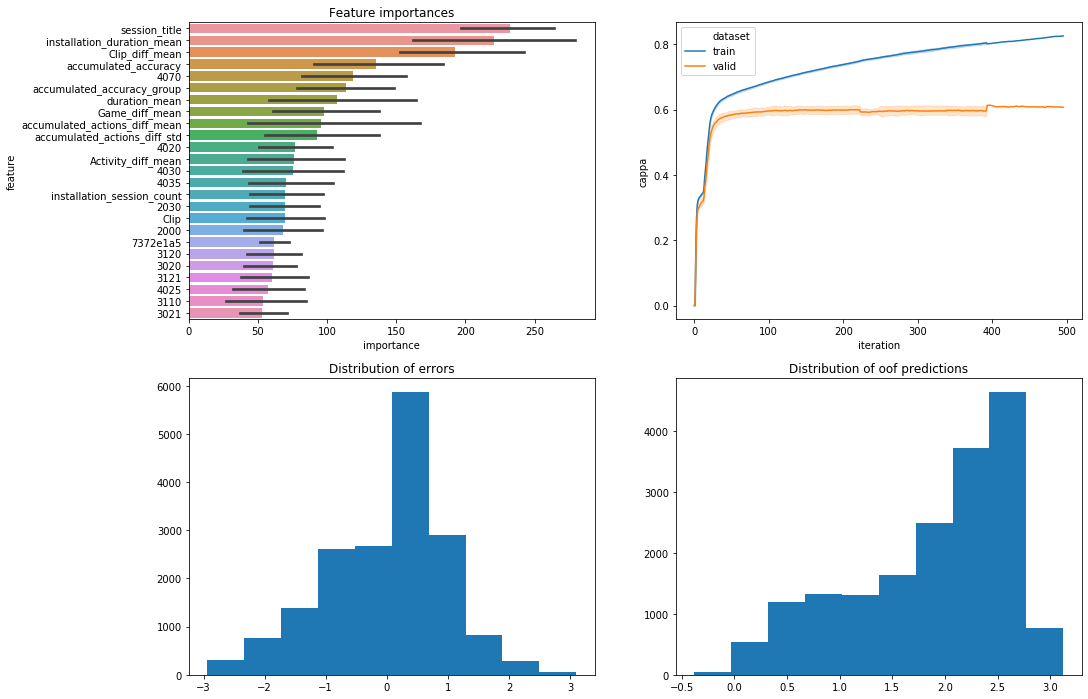

In [32]:
regressor_models = []
for i in range(5, 6):
    folds = GroupKFold(n_splits=i)
    regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
    regressor_model.fit(X=comp_train_df, y=y, folds=folds, params=params,
                        eval_metric='cappa', cols_to_drop=cols_to_drop)
    regressor_models.append(regressor_model)

In [33]:
all_models = [(i, regressor_model.scores['valid']) for (i, regressor_model) in enumerate(regressor_models)]
max_model = max(all_models, key=lambda iv : iv[1])
print(f'best model: {max_model}')
regressor_model1 = regressor_models[max_model[0]]

best model: (0, 0.6031499267078345)


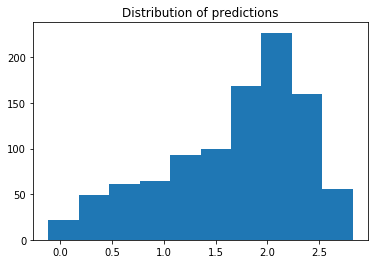

In [34]:
plt.hist(regressor_model1.predict(comp_test_df).reshape(1000))
plt.title('Distribution of predictions');

## Inference

In [35]:
%%time
pr1 = regressor_model1.predict(comp_train_df)

CPU times: user 13.6 s, sys: 628 ms, total: 14.2 s
Wall time: 1.31 s


In [36]:
get_class_bounds_coeff = get_class_bounds(y.to_numpy(), pr1.T.reshape(-1))
get_class_bounds_coeff

[1.2675178132236746, 1.8065463685144845, 2.136204802498857]

In [37]:
calculated_coeff = np.array(calculated_coeffs).mean(axis=0)
calculated_coeff

array([1.18420126, 1.72593155, 2.25158913])

In [38]:
optR = OptimizedRounder(calculated_coeff)
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients();
print(coefficients);
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

[1.12239907 1.73440321 2.22747255]


0.7326003285201435

In [39]:
# zero_threshhold = 1.12232214, one_threshhold = 1.73925866, two_threshhold = 2.22506454
pr1 = regressor_model1.predict(comp_test_df)
convert_regr_to_cat(pr1, zero_threshhold = coefficients[0], one_threshhold = coefficients[1], two_threshhold = coefficients[2])
pd.Series(pr1.reshape(1000)).value_counts(normalize=True)

2.0    0.342
1.0    0.226
3.0    0.222
0.0    0.210
dtype: float64

In [40]:
pr2 = regressor_model1.predict(comp_test_df)
convert_regr_to_cat(pr2, zero_threshhold = get_class_bounds_coeff[0], one_threshhold = get_class_bounds_coeff[1], two_threshhold = get_class_bounds_coeff[2])
pd.Series(pr2.reshape(1000)).value_counts(normalize=True)

3.0    0.290
0.0    0.260
2.0    0.231
1.0    0.219
dtype: float64

In [41]:
pr3 = regressor_model1.predict(comp_test_df)
convert_regr_to_cat(pr3)
pd.Series(pr3.reshape(1000)).value_counts(normalize=True)

2.0    0.336
1.0    0.230
3.0    0.224
0.0    0.210
dtype: float64

In [42]:
sample_submission_df = pd.read_csv(path/'sample_submission.csv')

In [43]:
selected_prediction = pr1
sample_submission_df['accuracy_group'] = selected_prediction.astype(int)
sample_submission_df.to_csv('submission.csv', index=False)

In [44]:
sample_submission_df.to_csv('submission.csv', index = False)

In [45]:
!head submission.csv

installation_id,accuracy_group
00abaee7,2
01242218,3
017c5718,3
01a44906,3
01bc6cb6,2
02256298,3
0267757a,2
027e7ce5,2
02a29f99,0


## Data Checks

In [46]:
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]
valid_ds = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy']
expected_ratios = valid_ds.apply(lambda x : feature_engineering.convert_to_accuracy_group(x)).value_counts(normalize=True)
expected_ratios

3    0.450747
0    0.283066
1    0.137244
2    0.128943
Name: accuracy, dtype: float64

In [47]:
pred_ratios = sample_submission_df['accuracy_group'].value_counts(normalize=True)
pred_ratios

2    0.342
1    0.226
3    0.222
0    0.210
Name: accuracy_group, dtype: float64

In [48]:
pred_ratios_list = np.array(pred_ratios.sort_index().tolist())
expected_ratios_list = np.array(expected_ratios.sort_index().tolist())
pred_ratios_list, expected_ratios_list

(array([0.21 , 0.226, 0.342, 0.222]),
 array([0.28306586, 0.13724405, 0.128943  , 0.45074709]))

In [49]:
prod = ((pred_ratios_list - pred_ratios_list.mean()) * (expected_ratios_list - expected_ratios_list.mean())).mean() / (pred_ratios_list.std() * expected_ratios_list.std())
prod

-0.548559511526971

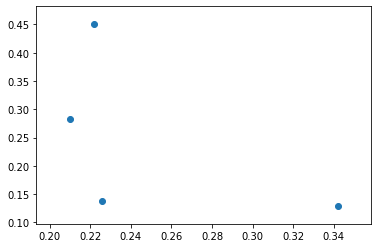

In [50]:
plt.scatter(pred_ratios_list, expected_ratios_list);